# Assignment

# Phase 1 - Theoretical questions

**Q1. Define the problem of “vanishing” and “exploding” gradients.**


In the world of Neural Networks, a gradient is a vector quantity which is calculated during the forward pass phase. This quantity is then used to update weights in the right measure and direction to reach a minimum, and therefore minimize the loss function.


 At times, these gradients accumulate and causes the network to take huge steps, thus destabilizing the learning process. This rapid growth of these gradients is the reason behind its name - exploding gradient problem. Using L1 or L2 regularization on the weights will help tackle the exploding gradient problem.

 
On the other hand, in deeper neural networks, during the backpropagation phase, small gradients have to travel through a lot of layers and undergo multiple matrix operations. This causes the gradient to exponentially diminish. By the time these gradients reach the frontal layers, they become almost non-existent. Weight updates stop taking place in these layers, and hence, this challenge is called the vanishing gradient problem.

**Q2. Enumerate 2 or 3 examples real-world tabular data challenges that might impact the learning process of a Deep Learning model.**

Few properties of data that can affect a Deep learning model are as follows:
1. **Class imbalance**: In classification problems, if we have a situation where the number of samples in a certain class outnumbers the samples in another class, then the data is said to be imbalanced. Naturally, data of the larger calss will appear more often during the training process, and this will cause our model to be biased towards that class. F1 metric is a good option to slightly remove this bias. However, other methods of syntetic data creation yields better results.
2. **Multicollinearity**: The performance of a deep learning model heavily leans on the quality of the input data. At times more than one variables can be said to be corelated if the value of the second variable changes when the value of the first one is altered. The presence of such variables. This means that one of the predictor variables can be predicted by the value of another one. This will give rise to skewed results and therefore must be weeded. Its a good habit to prune the data off highly corelated variables.
3. **Data size**: More the data the merrier it is. If a deep learning model has plenty of good good data, it will be able to draw better patterns between them and come out with good results. Large datasets result in our model having a low variance. Higher variance means that our model hasn't generalised well. While our model perfectly fits the train data, but it will be surprised by the test data and will perform poorly. In case the number of data points are low. Smart augmentation techniques must be followed to simulate more data points.



#Phase 2 - Code challenge
**problem statement:** Having the dataset for hourly SO2 concentrations in Sacramento County as work base,propose and ​implement some pre-processing steps using your preferred tools. ​Justify all the proposed pre-processing steps.

Implement a simple RNN architecture to perform predictions for the daily max hourly SO2 concentration for the State of California, using Tensorflow (preferably Tensorflow 2.0 version). 

## 1. Connecting G-Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd gdrive/My\ Drive/SO2\ Prediction

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content/gdrive/My Drive/SO2 Prediction


## 2. Loading Libraries

In [0]:
#installing
!pip install outlier_utils

In [0]:
#Magic Commands
%matplotlib inline
%tensorflow_version 2.x


#Plotting libraries
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

#Utils
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from __future__ import absolute_import, division, print_function, unicode_literals
from tqdm import tqdm_notebook
from io import BytesIO
import requests

#pre-processing libraries
from sklearn import preprocessing
from keras.utils import to_categorical
from outliers import smirnov_grubbs as grubbs
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

#Tensorflow
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

TensorFlow 2.x selected.


Using TensorFlow backend.


## 3. Loading Data

In [0]:
data_path = "./Data/California_SO2_Measures.csv"
df = pd.read_csv(data_path)

## 4. Exploring the Data
### Samples

In [0]:
df.sample(5)

,Date,Source,Site ID,POC,Daily Max 1-hour SO2 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
4925,02/08/2019,AQS,60831020,2,0.0,ppb,0,UCSB West Campus,23,96.0,42401,Santa Barbara,34.414942,-119.879511
4464,02/17/2019,AQS,60792004,1,0.0,ppb,0,Mesa2,23,96.0,42401,San Luis Obispo,35.020830,-120.563880
4348,06/20/2019,AQS,60731022,1,0.1,ppb,0,El Cajon - Lexington Elementary School,20,83.0,42401,San Diego,32.789561,-116.944222
3693,01/19/2019,AQS,60710306,1,1.3,ppb,1,Victorville-Park Avenue,23,96.0,42401,San Bernardino,34.510961,-117.325540
3915,03/15/2019,AQS,60711234,1,1.1,ppb,1,Trona - Athol/Telescope #2,23,96.0,42401,San Bernardino,35.774170,-117.371400


### Description

1. **Date**: The date when that data point was collected.
2. **Source**: Source of information- Air Quality Survey.
3. **Site ID**: Each survey site has a unique ID. 
4. **POC**: Stands for “Parameter Occurrence Code”,used to distinguish different instruments that measure the same parameter at the same site ([Source](https://aqs.epa.gov/aqsweb/documents/AQS_Format.html)).
5. **target**: Max SO2 concentration of a given day at a given site. 
6. **UNITS**: The unit the measurement is taken in - ppb(Parts Per Billion.)
7. **DAILY_AQI_VALUE**: Air Quality Index of the given date at a given place.
8. **Site Name**: Name of the Survey Site.
9. **DAILY_OBS_COUNT**: Total number of observations taken in a day.
10.	**PERCENT_COMPLETE**: Percentage of the number of hourly observations taken in a day(24 hours).
11. **AQS_PARAMETER_CODE**: The unique code for SO2 according to AQS, which is 42401 ([Source](https://aqs.epa.gov/aqsweb/documents/codetables/pollutant_standards.html)).
12. **COUNTY**: Name of the county where the survey site is located.
13. **SITE_LATITUDE**: Latitude of the survey site.
14. **SITE_LONGITUDE**: Longitude of the survey site.




In [0]:
print(df.shape)

(5998, 14)


In [0]:
df.rename({'Daily Max 1-hour SO2 Concentration':'target'}, axis = 1, inplace=True)

### Checking Data Description

In [0]:
df.describe()

,Site ID,POC,target,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,SITE_LATITUDE,SITE_LONGITUDE
count,5.998000e+03,5998.000000,5998.000000,5998.000000,5998.00000,5998.000000,5998.0,5998.000000,5998.000000
mean,6.046053e+07,1.616372,1.177793,1.033178,22.74975,94.958319,42401.0,36.327223,-120.350974
std,3.128210e+05,1.908717,6.320001,4.474566,1.12777,4.636235,0.0,2.077436,2.097841
min,6.001001e+07,1.000000,-0.300000,0.000000,18.00000,75.000000,42401.0,32.676180,-124.179490
25%,6.013100e+07,1.000000,0.200000,0.000000,22.00000,92.000000,42401.0,34.462450,-122.233229
50%,6.037401e+07,1.000000,0.600000,0.000000,23.00000,96.000000,42401.0,37.348497,-120.457500
75%,6.079200e+07,1.000000,1.400000,1.000000,23.00000,96.000000,42401.0,38.006311,-118.330783
max,6.095000e+07,9.000000,347.000000,200.000000,24.00000,100.000000,42401.0,40.776780,-115.483070


### Checking for null values

In [0]:
print ("total null values: ", df.isna().sum().sum())

total null values:  0


This dataset has zero missing values.

### Corelation Matrix

A correlation Matrix tells us the correlation of each variable with repspect to the others. This is used o understand how the variables change with respect to another. This will help us better pre process the data set.

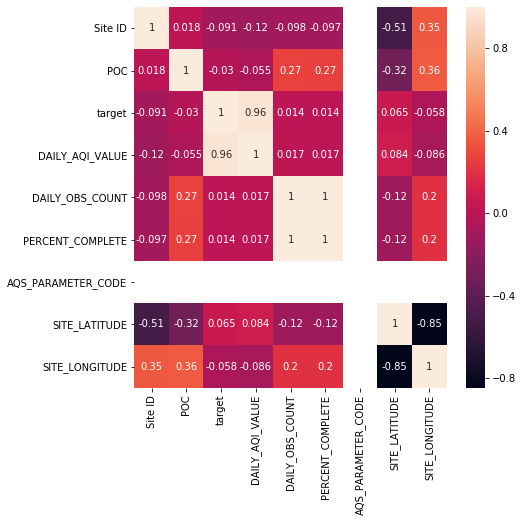

In [0]:
plt.figure(figsize = (7,7))
sns.heatmap(df.corr(), annot=True)

**Few Observations:**
1. Daily DAILY_AQI_VALUE and Daily Max 1-hour SO2 Concentration are highly corelated. 

2. DAILY_OBS_COUNT and PERCENT_COMPLETE are completley correlated and therefore only one of them needs to be used ( As both their correlation values are same when compared to other values, we can use only one.)Also, DAILY_OBS_COUNT means the total number of hourly observations taken in a day and PERCENT_COMPLETE is the percentage of DAILY_OBS_COUNT to total number of a hours, i.e., 24. Therefore, they both are.)

3. Site Latitude and longitude are negatively corelated.

### Data Types
Knowing the data types will help us easily manipulate them.

In [0]:
df.dtypes

Date                   object
Source                 object
Site ID                 int64
POC                     int64
target                float64
UNITS                  object
DAILY_AQI_VALUE         int64
Site Name              object
DAILY_OBS_COUNT         int64
PERCENT_COMPLETE      float64
AQS_PARAMETER_CODE      int64
COUNTY                 object
SITE_LATITUDE         float64
SITE_LONGITUDE        float64
dtype: object

### Checking unique values for certain columns.

In [0]:
for col in df.columns:
  print('Number of unique Values in {} are {}'.format(col, df[col].nunique()))

Number of unique Values in Date are 304
Number of unique Values in Source are 1
Number of unique Values in Site ID are 28
Number of unique Values in POC are 4
Number of unique Values in target are 116
Number of unique Values in UNITS are 1
Number of unique Values in DAILY_AQI_VALUE are 23
Number of unique Values in Site Name are 28
Number of unique Values in DAILY_OBS_COUNT are 7
Number of unique Values in PERCENT_COMPLETE are 7
Number of unique Values in AQS_PARAMETER_CODE are 1
Number of unique Values in COUNTY are 15
Number of unique Values in SITE_LATITUDE are 28
Number of unique Values in SITE_LONGITUDE are 28


Since the values for the *Source, UNITS* and *AQS_PARAMETER_CODE* columns are constant. Therefore, we will remove them.

### Date

In [0]:
df['Date'] = df.Date.apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))
print('Min date: {}'.format(df['Date'].min()))
print('Max date: {}'.format(df['Date'].max()))
delta = df['Date'].max() - df['Date'].min()
print("Total number of Days = {}".format(int(delta.days)+1))

Min date: 2019-01-01 00:00:00
Max date: 2019-10-31 00:00:00
Total number of Days = 304


#### Checking for breaks in **Dates**

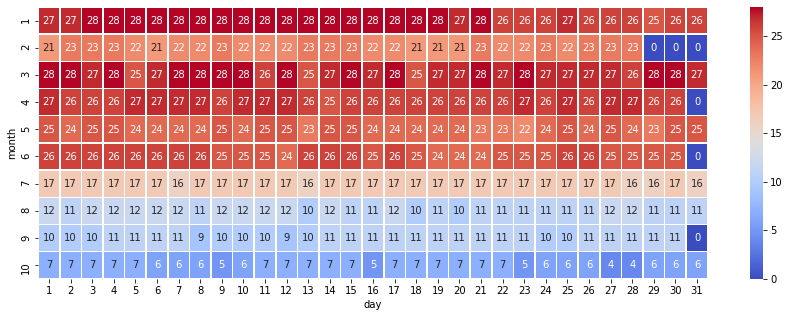

In [0]:
df['month'] = df.Date.apply(lambda x: x.month)
df['day'] = df.Date.apply(lambda x: x.day)

df_pivot = pd.pivot_table(df, index='month',columns=['day'], values="target", aggfunc = 'count', fill_value=0)
plt.figure(figsize = (15,5))
sns.heatmap(df_pivot, 
            annot=True, 
            fmt="g", 
            linewidths=.5, 
            cmap='coolwarm');  

There are no breaks in the data and this means that the SO2 levels were collected everyday. However, it is evident from the heatmap that not all stations were continously collecting samples. We have less data points for the month of October than we had in January.

### target

A box and whiskers plot will help us know better about the data as we can learn about the minimum, first quartile, median, third quartile, and maximum values of our target variable.

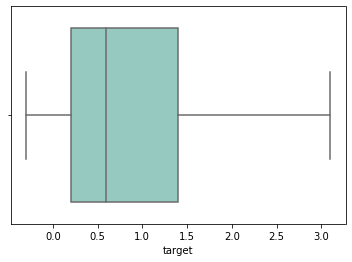

In [0]:
ax = sns.boxplot(x=df["target"],  palette="Set3", showfliers=False)
ax.plot();

In [0]:
df.head()

,Date,Source,Site ID,POC,target,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE,month,day
0,2019-01-01,AQS,60010011,1,1.0,ppb,1,Oakland West,22,92.0,42401,Alameda,37.814781,-122.282347,1,1
1,2019-01-02,AQS,60010011,1,4.0,ppb,6,Oakland West,22,92.0,42401,Alameda,37.814781,-122.282347,1,2
2,2019-01-03,AQS,60010011,1,1.4,ppb,1,Oakland West,22,92.0,42401,Alameda,37.814781,-122.282347,1,3
3,2019-01-04,AQS,60010011,1,2.4,ppb,3,Oakland West,22,92.0,42401,Alameda,37.814781,-122.282347,1,4
4,2019-01-05,AQS,60010011,1,0.5,ppb,0,Oakland West,22,92.0,42401,Alameda,37.814781,-122.282347,1,5


### Sites

From the dataset, it is evident that there are unique 28 sites and naturally, each site would have a unique site-id, and also a unique set of coordinates. We will perform a confirmation test by grouping the values and observing the frequencies.

In [0]:
df.groupby([ 'Site ID', 'Site Name','SITE_LONGITUDE', 'SITE_LATITUDE']).size().reset_index(name='Freq')

,Site ID,Site Name,SITE_LONGITUDE,SITE_LATITUDE,Freq
0,60010011,Oakland West,-122.282347,37.814781,292
1,60130002,Concord,-122.026154,37.936013,244
2,60130006,Richmond - 7th St.,-122.364852,37.948172,262
3,60131001,Crockett - Kendall Ave,-122.233229,38.054920,275
4,60131002,Bethel Island,-121.641918,38.006311,265
5,60131004,San Pablo,-122.356811,37.960400,268
6,60132001,Martinez - Jones St.,-122.134467,38.012816,266
7,60190011,Fresno - Garland,-119.773210,36.785380,211
8,60231004,Jacobs,-124.179490,40.776780,246
9,60250005,Calexico-Ethel Street,-115.483070,32.676180,120


Just as we had assumed, each site has site ID, a site name, and their geo-coordinates. Keeping all these values will end up throwing the model off. Since each site ID has a unique name, and a unique set of geo coordinates. We will hot encoded the Site names and remove all other correlated values.

### Counties
Knowing the locations of these survey sites will give us a better understanding of the data. Survey sites that are closeby will experience similar air quality.

In [0]:
#MAP PLOT from plotly documnetation. Source: https://plot.ly/python/county-choropleth/

data = [dict(
    type='scattergeo',
    lon = df['SITE_LONGITUDE'],
    lat = df['SITE_LATITUDE'],
    hoverinfo = 'text',
    text = "SITE: " + df['Site Name'] + "; COUNTY: "+df["COUNTY"],
    mode = 'markers',
    marker=dict(
        sizemode = 'area',
        sizeref = 1,
        size= 10 ,
        line = dict(width=1,color = "white"),
        opacity = 0.7),
)]

layout = dict(
    title = 'AQI Survey Sites',
    hovermode='closest',
    geo = dict(showframe=False, scope = "usa", showland=True, showcoastlines=False, showcountries=True,
               countrywidth=1,
              landcolor = 'rgb(217, 217, 217)',
              subunitwidth=1)
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)


### Trends in Sacremento County
From the map above, Sacremento county has  only 1 AQS site. Let us study the trends.

#### Plotting SO2 Concentration w.r.t. Date 

In [0]:
df_sacramento = df[df['Site Name']== 'Sacramento-Del Paso Manor'][['Date', 'target']]
iplot([{
    'x': df_sacramento['Date'],
    'y': df_sacramento['target']
      }] )

#### Rolling statistics to observe Stationarity 

Usually, time-series data has a trend to it. E.g., if we look at the time-series for the sale of sweaters, we will be able to see that the sales go up in the winter season, and this behaviour is called a trend. Time-series with such trends are not stationary, and this will skew our predictions. A visual way to identify whether our data has any trend is by observing the mean and variance. If these values remain constant over a period of time, then we conclude that our series is stationary. 

We will use rolling statistcs for this test. We will calculate the mean and standard deviation of the data and then plot it against the time series to observe any trend.

In [0]:
window_size = 20
df_sacramento['rolling_mean'] = df_sacramento[['Date', 'target']].rolling(window_size).mean().rename({'target':'mean'}, axis =1)
df_sacramento['rolling_std_dev'] = df_sacramento[['Date', 'target']].rolling(window_size).std().rename({'target':'std_dev'}, axis =1)
df_sacramento.dropna(inplace=True)

iplot([{
    'x': df_sacramento['Date'],
    'y': df_sacramento[col],
    'name': col
}  for col in df_sacramento.columns[1:]])

The rolling mean does not change much with respect to time. Therefore, our series can be stationary. A statistical test, like the Augmented Dickey-Fuller test, will confirm our hypothesis. 

#### Dickey-Fuller Test

This test is one of the most popular techniques to check the stationarity of time-series data.  We start by assuming that our dataset is not stationary, and then we proceed to test our hypothesis. 

In [0]:
df_sacramento.set_index('Date', inplace= True)
test_results = adfuller(df_sacramento['target'], autolag='AIC')

table = PrettyTable()
table.field_names = ["Name", "Value"]

table.add_row(['Test statistic', test_results[0]])
table.add_row(['p-value', test_results[1]])
table.add_row(['Number of Lags', test_results[2]])
table.add_row(['Number of Observations', test_results[3]])
table.add_row(['Critical Value (1%)', test_results[4]['1%']])
table.add_row(['Critical Value (5%)', test_results[4]['5%']])
table.add_row(['Critical Value (10%)', test_results[4]['10%']])

print(table)

+------------------------+-----------------------+
|          Name          |         Value         |
+------------------------+-----------------------+
|     Test statistic     |   -3.672791727879195  |
|        p-value         | 0.0045125534979602415 |
|     Number of Lags     |           4           |
| Number of Observations |          219          |
|  Critical Value (1%)   |   -3.460567372610299  |
|  Critical Value (5%)   |   -2.874829809033386  |
|  Critical Value (10%)  |   -2.573853225954421  |
+------------------------+-----------------------+


From the output above, I observed the following:
1. **p-value < 0.05**: The p-value is an order of magnitude smaller than 0.05.
2. **The low Test statistic**: Test-statistic for this dataset is approximately -3.7, which is lower than the critical value at 1%.

Looking at both these cases, it can be inferred that our model is **stationary**.

## 5. Pre-processing

###Working days
While Industries are a major contributor to SO2 pollution worldwide, but according to a [study](https://acidrainproject08.weebly.com/about-sulfur-dioxide.html), 5% So2 pollution can be attributed to transportation.

![SO2](https://acidrainproject08.weebly.com/uploads/6/8/2/7/682769/3735040.gif)

Naturally, the number of vehicles on the road on any given weekday is much more than that on weekends. By grouping the SO2 values and checking for a difference in the mean SO2 value on weekdays, and weekends, we can create a new feature. (only, if there is significant difference between SO2 levels on a weekend and a weekday.)

In [0]:

test_df = pd.concat((df.Date.apply(lambda x: 0 if x.dayofweek > 5 else 1), df.target), axis = 1)
test_df.groupby(['Date']).mean()['target'] 

Date
0    1.024089
1    1.203206
Name: target, dtype: float64

Since the difference between SO2 levels on weekends and weekdays isn't significant. We **won't be using** this as a feature.

### Removing unwanted columns.

In [0]:
df.drop(['Source', 'UNITS', 'AQS_PARAMETER_CODE', 'Site ID', 'SITE_LONGITUDE', 'SITE_LATITUDE', 'PERCENT_COMPLETE'], axis = 1, inplace= True)
df.set_index('Date', inplace = True)

In [0]:
df.head()

,POC,target,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,COUNTY,month,day
Date,,,,,,,,
2019-01-01,1,1.0,1,Oakland West,22,Alameda,1,1
2019-01-02,1,4.0,6,Oakland West,22,Alameda,1,2
2019-01-03,1,1.4,1,Oakland West,22,Alameda,1,3
2019-01-04,1,2.4,3,Oakland West,22,Alameda,1,4
2019-01-05,1,0.5,0,Oakland West,22,Alameda,1,5


### One Hot Encoding **Counties**

In [0]:
county_ohe = pd.get_dummies(df['COUNTY'],prefix='county_')
df = pd.concat([df, county_ohe], axis = 1)
df.drop(['COUNTY'], axis = 1, inplace= True)
print(df.shape)

(5998, 22)


### One Hot Encoding **Site Names**

In [0]:
site_ohe = pd.get_dummies(df['Site Name'],prefix='site_')
df = pd.concat([df, site_ohe], axis = 1)
df.drop(['Site Name'], axis = 1, inplace= True)
print(df.shape)

(5998, 49)


## 6. Splitting into train and test set

In [0]:
train_data = df.query('Date < "2019-07-01"')
valid_data = df.query('Date >= "2019-07-01" and Date < "2019-08-01"')
test_data = df.query('Date >= "2019-08-01"')
sacremento_test = test_data[test_data['site__Sacramento-Del Paso Manor'] == 1]
sacremento_test_dates = sacremento_test.index

train_target = np.asarray(train_data.pop('target'))
valid_target = np.asarray(valid_data.pop('target'))
test_target = np.asarray(test_data.pop('target'))
sacremento_test_target = np.asarray(sacremento_test.pop('target')) 

### Normalizing the DataFrames

We are normalizing the train, test, and validation sets individually to prevent a data leak. We do not want to assume the scale of the data in the unseen sets (test and validation.)

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

train_target, train_data[:] =  target_scaler.fit_transform(train_target.reshape(-1, 1)), scaler.fit_transform(train_data[:])
valid_target, valid_data[:] = target_scaler.transform(valid_target.reshape(-1, 1)), scaler.transform(valid_data[:])
test_target, test_data[:] = target_scaler.transform(test_target.reshape(-1, 1)), scaler.transform(test_data[:])
sacremento_test_target, sacremento_test[:] = target_scaler.transform(sacremento_test_target.reshape(-1, 1)), scaler.transform(sacremento_test[:])

### Creating timesteps

Since we are dealing with time series data, we will feed the data in the form of timesteps, where we feed the datato the model with a lag and it has to predict the values in the future, by that amount.

In [0]:
def create_timesteps(X, y, time_steps=1):
    data, targets = [], []
    for n in range(len(X) - time_steps):
        value = X.iloc[n:(n + time_steps)].values
        data.append(value)        
        targets.append(y[n + time_steps])
    return np.array(data), np.array(targets)
    
time_steps = 5
train_data, train_targets = create_timesteps(train_data, train_target, time_steps)
valid_data, valid_targets = create_timesteps(valid_data, valid_target, time_steps)
test_data, test_targets = create_timesteps(test_data, test_target, time_steps)
sacremento_test, sacremento_test_target = create_timesteps(sacremento_test, sacremento_test_target, time_steps)

## 7. Hyper-parameters

In [0]:
epochs = 100
batch_size = 64

## 8.  Neural Modelling

### Model Architecture

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(4, input_shape=(train_data.shape[1], train_data.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 4)                 212       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


### Defining Loss object and optimizer

In [0]:
optimizer = tf.keras.optimizers.RMSprop()
loss_object = tf.keras.losses.MeanSquaredError()

train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

### Defining Custom Train and Test Functions

In [0]:
@tf.function
def train_step(input_series, target):
  with tf.GradientTape() as tape:
    predictions = model(input_series)
    loss = loss_object(target, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)

In [0]:
@tf.function
def test_step(input_series, target):
  predictions = model(input_series)
  t_loss = loss_object(target, predictions)

  test_loss(t_loss)

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_targets)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((valid_data, valid_targets)).batch(batch_size)

## 9. Training the model

In [0]:
history = {'train_loss':[], 'validation_loss':[]}
for epoch in tqdm_notebook(range(epochs)):
  
  train_loss.reset_states()
  test_loss.reset_states()
 
  for input_series, labels in train_ds:
    train_step(input_series, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {:0>2d}, Loss: {:.7f}, Validation Loss: {:.7f}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        test_loss.result()))
  
  history['train_loss'].append(train_loss.result().numpy())
  history['validation_loss'].append(test_loss.result().numpy())



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 01, Loss: 0.0701380, Validation Loss: 0.0551292
Epoch 02, Loss: 0.0325997, Validation Loss: 0.0378523
Epoch 03, Loss: 0.0189343, Validation Loss: 0.0274964
Epoch 04, Loss: 0.0121864, Validation Loss: 0.0209991
Epoch 05, Loss: 0.0082962, Validation Loss: 0.0167585
Epoch 06, Loss: 0.0057999, Validation Loss: 0.0137366
Epoch 07, Loss: 0.0041579, Validation Loss: 0.0114021
Epoch 08, Loss: 0.0030914, Validation Loss: 0.0095792
Epoch 09, Loss: 0.0024059, Validation Loss: 0.0080724
Epoch 10, Loss: 0.0019

### Plotting Model History

In [0]:
def plot_history(history):
  
  loss_values = history['train_loss']
  val_loss_values = history['validation_loss']
  
  if len(loss_values) == 0:
    print("Incomplete Data")
    return 0
  
  no_epochs = [n for n in range(1, len(loss_values)+1)]

  fig = go.Figure()

  fig.add_trace(
      go.Scatter(
          x=no_epochs,
          y=loss_values,
          name = 'Train Loss'
      ))

  fig.add_trace(
      go.Scatter(
          x=no_epochs,
          y=val_loss_values ,
          name = 'Validation Loss' 
      ))

  fig.update_layout(
      title="Loss graph",
      xaxis_title="Epochs",
      yaxis_title="Loss")

  fig.show()
  
  
plot_history(history)

### Saving the model

In [0]:
model.save("./Models/final_model.h5")

## 10. Testing the model

### Testing the model.

In [0]:
model.compile(optimizer, loss_object)
model.evaluate(test_data, test_targets)

859/859 [==============================] - 0s 255us/sample - loss: 0.0021


0.002051572712688422

The average Mean Squared Error on the test set is **0.0020**.

### Plotting the forecast for Sacremento

In [0]:
preds = model.predict(sacremento_test)

In [0]:
inverse_sacremento_targets = target_scaler.inverse_transform(sacremento_test_target.reshape(-1, 1))
inverse_preds = target_scaler.inverse_transform(preds)

In [0]:
df_sacremento_pred = pd.DataFrame([x for x in zip(sacremento_test_dates, inverse_preds.flatten())], columns = ['Date', 'target'])
df_sacremento_pred.set_index('Date', inplace= True)

In [0]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_sacramento.index,
        y=df_sacramento.target,
        name = 'Actual'
    ))

fig.add_trace(
    go.Scatter(
        x=df_sacremento_pred.index,
        y=df_sacremento_pred.target,
        name = 'Forecasted'
    ))

fig.update_layout(
    title="SO2 concentration in Sacremento",
    xaxis_title="Date",
    yaxis_title="Hourly Average SO2 Concentration")

fig.show()